In [1]:
# Import Python modules
import os, sys
import yaml
import numpy as np
import pandas as  pd
import xarray as xr
from datetime import timedelta, date
import textwrap

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from ar_funcs import get_ar_days, duration_stats
from constants import ucsd_colors

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-clim/share/proj failed


In [2]:
# Set up paths

path_to_data = '/work/dnash/SEAK_clim_data/downloads/AR_catalog/'      # project data -- read only
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
# label strings
ivt_units = 'kg m$^{-1}$ s$^{-1}$'

# Select lat/lon grid
# bnds = [360-175., 360-120., 50., 60.] # extend of AK
bnds = [360-141., 360-130., 54., 61.] # extent of SEAK
ext1 = [-141.5, -130.0, 54., 61.5] # extent of SEAK
lonmin, lonmax, latmin, latmax = bnds

# set start and end dates to match WRF data
start_date = '1980-01-01 0:00'
end_date = '2019-12-31 23:00'

In [4]:
%%time
filename =  'globalARcatalog_ERA-Interim_1979-2019_v3.0.nc'
ar_filename = path_to_data + filename
ds = xr.open_dataset(ar_filename)
# ds = ds.assign_coords(lon=(((ds.lon + 180) % 360)-180))
# ds
da = ds.sel(time=slice(start_date, end_date), lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))
da

CPU times: user 363 ms, sys: 121 ms, total: 483 ms
Wall time: 4.32 s


<xarray.Dataset>
Dimensions:      (lon: 8, lat: 5, lev: 1, time: 57952, ens: 1)
Coordinates:
  * lon          (lon) float64 219.0 220.5 222.0 223.5 225.0 226.5 228.0 229.5
  * lat          (lat) float64 54.0 55.5 57.0 58.5 60.0
  * lev          (lev) float64 1e+03
  * time         (time) datetime64[ns] 1980-01-01 ... 2019-08-31T18:00:00
  * ens          (ens) float64 1.0
Data variables: (12/53)
    islnd        (lat, lon) float32 ...
    iscst        (lat, lon) float32 ...
    shapemap     (ens, time, lev, lat, lon) float32 ...
    axismap      (ens, time, lev, lat, lon) float64 ...
    tnsctmap     (ens, time, lev, lat, lon) float64 ...
    lflocmap     (ens, time, lev, lat, lon) float32 ...
    ...           ...
    axisidx      (ens, time, lev, lat, lon) float32 ...
    axislon      (ens, time, lev, lat, lon) float32 ...
    axislat      (ens, time, lev, lat, lon) float32 ...
    xtnsctidx    (ens, time, lev, lat, lon) float32 ...
    numobj       (ens, time, lev, lat, lon) float32 ...
    intblosto    (ens, lev, lat, lon) float64 ...
Attributes:
    title:                 Global Atmospheric River Database
    version:               2022.03.22
    creation_date:         22-Mar-2022 11:12:14
    tARget_version:        1.300
    dimension_convention:  5-d (nlon x nlat x nlev x ntime x nens) variables ...
    references:            (1) Guan, B., and D. E. Waliser (2015), Detection ...

In [5]:
## six communities
xs = [-135.4519, -135.3277, -135.8894, -139.671, -133.1358, -132.4009]
ys = [58.1122, 59.4538, 59.3988, 59.5121, 55.4769, 55.5400]
lbl1 = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']
lbl_align = ['center', 'left', 'right', 'center', 'right', 'left'] # where the labels go

In [6]:
lfloc = da.lflocmap.squeeze()
lfloc_ct = lfloc.count('time')
lfloc_ct

<xarray.DataArray 'lflocmap' (lat: 5, lon: 8)>
array([[   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 2367,  112],
       [   0,    0,    0,    0,    0,  608,    0,    0],
       [   0,    0,    0, 1431,   84,    0,    0,    0],
       [ 382,   33,   34,    0,    0,    0,    0,    0]])
Coordinates:
  * lon      (lon) float64 219.0 220.5 222.0 223.5 225.0 226.5 228.0 229.5
  * lat      (lat) float64 54.0 55.5 57.0 58.5 60.0
    lev      float64 1e+03
    ens      float64 1.0

In [7]:
clim_freq = lfloc_ct.squeeze().values

index_clim = np.flatnonzero(clim_freq)
print(index_clim.shape)
landfall_clim = clim_freq.ravel()[index_clim]
print(landfall_clim.shape)

clim_lons, clim_lats = np.meshgrid(lfloc_ct.lon, lfloc_ct.lat)
clim_lat_list = clim_lats.ravel()[index_clim]
print(clim_lat_list.shape)
clim_lon_list = clim_lons.ravel()[index_clim]
print(clim_lon_list.shape)


(8,)
(8,)
(8,)
(8,)


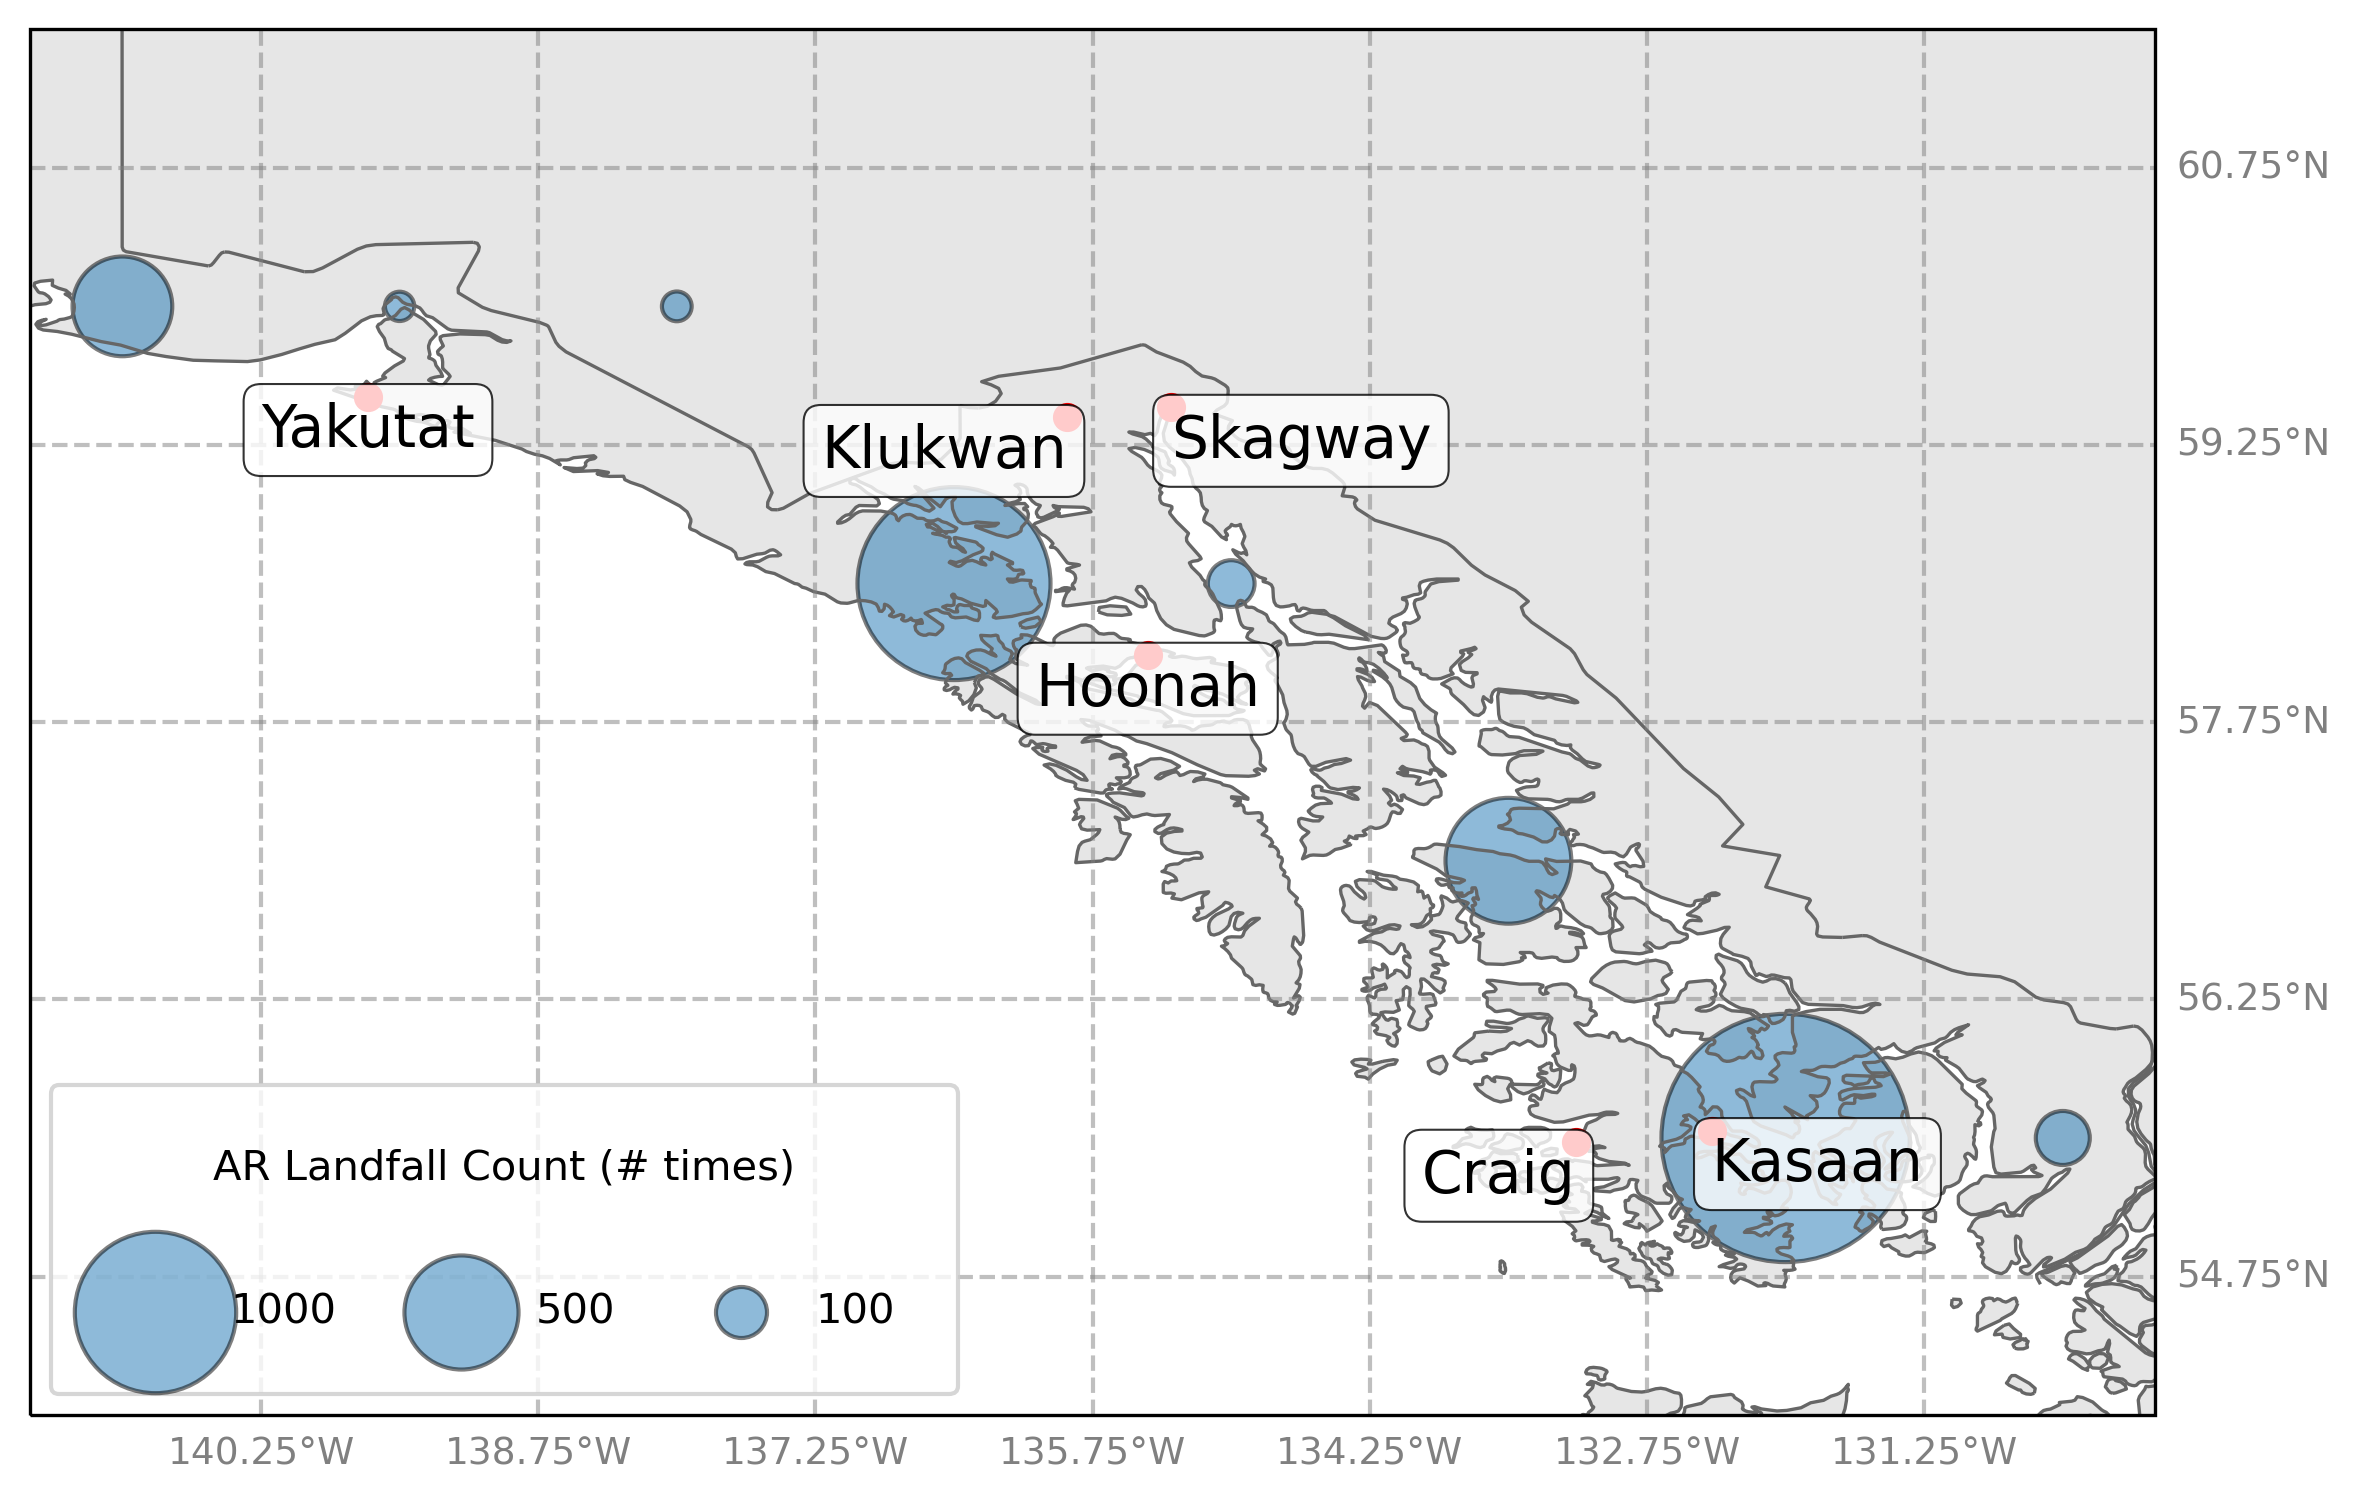

In [8]:
fname = path_to_figs + 'ar-landfall_freq'
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((12.,6.))
fig.dpi = 300

# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

# Set tick/grid locations
xticks = np.arange(da.lat.min()+0.75,da.lat.max()+1.75,1.5)
yticks = np.arange(da.lon.min()-360.75,da.lon.max()-360.75+1.5,1.5)
    
ax = plt.axes(projection=mapcrs)
ax.set_extent(ext1, crs=datacrs)

# Add map features (continents and country borders)
ax.add_feature(cfeature.LAND, facecolor='0.9')      
ax.add_feature(cfeature.BORDERS, edgecolor='0.4', linewidth=0.8)
ax.add_feature(cfeature.COASTLINE, edgecolor='0.4', linewidth=0.8)

## Add ERA-Interim Gridlines and Labels
gl = ax.gridlines(crs=datacrs, draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(yticks)
gl.ylocator = mticker.FixedLocator(xticks)
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()
gl.xlabel_style = {'size': 9, 'color': 'gray'}
gl.ylabel_style = {'size': 9, 'color': 'gray'}

# Bubbles
x = clim_lon_list
y = clim_lat_list 
z = landfall_clim
scl = 1.5
sc = ax.scatter(x, y, s=z*scl, c='tab:blue', marker='o', alpha=0.5, transform=mapcrs, edgecolors='k')

# legend
    
msizes = [1000*scl, 500*scl, 100*scl]
markers = []
for size in msizes:
    markers.append(plt.scatter([],[], s=size, c='tab:blue', edgecolors='k', label=(int(size/scl)), alpha=0.5))

ax.legend(handles=markers, loc='lower left', labelspacing=2.5, borderpad=1.5, title='AR Landfall Count (# times)', ncol=3)

# need this to fix annotate transform
transform = datacrs._as_mpl_transform(ax)

## Plot the locations of the focus communities
# zip joins x and y coordinates in pairs
for x,y,z,ha in zip(xs,ys, lbl1, lbl_align):

    # Plot Location of pts
    ax.plot(x, y, 'ro', markersize=6, transform=datacrs)

    ax.annotate(z, # this is the text
               (x,y), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,-12), # distance from text to points (x,y)
                ha=ha, # horizontal alignment can be left, right or center
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="k", lw=0.5, alpha=0.8),
                xycoords=transform,
                zorder=102,
                fontsize=14)

# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
plt.show()

In [9]:
# kasaan = lfloc.sel(lat=55.5, lon=360-132)
lfdates = lfloc.where(lfloc > 0, drop=True).time.values # only pulls the dates where an AR made landfall in SE AK
print('No. of AR landfalls in SE AK:', len(lfdates))

kidmap = da.kidmap.squeeze()
# ardates = kidmap.where(kidmap > 0, drop=True).time.values # pulls the dates when an AR object is within bbox 
# print('No. of AR objects near SE AK:', len(ardates))

No. of AR landfalls in SE AK: 5051


In [10]:
lfloc.where(lfloc > 0, drop=True)

<xarray.DataArray 'lflocmap' (time: 5051, lat: 4, lon: 8)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan,  2., nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan,  2., nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan,  2., nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 219.0 220.5 222.0 223.5 225.0 226.5 228.0 229.5
  * lat      (lat) float64 55.5 57.0 58.5 60.0
    lev      float64 1e+03
  * time     (time) datetime64[ns] 1980-01-05T18:00:00 1980-01-06 ... 2019-08-27
    ens      float64 1.0
Attributes:
    long_name:  Landfall Location
    units:      none

In [13]:
tmp = lfloc.sel(time='2018-01-16T18:00:00.000000000').values.flatten()
tmp[np.logical_not(np.isnan(tmp))]

array([], dtype=float32)

In [14]:
lfloc.sel(time='2018-01-16T18:00:00.000000000')

<xarray.DataArray 'lflocmap' (lat: 5, lon: 8)>
array([[nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan]], dtype=float32)
Coordinates:
  * lon      (lon) float64 219.0 220.5 222.0 223.5 225.0 226.5 228.0 229.5
  * lat      (lat) float64 54.0 55.5 57.0 58.5 60.0
    lev      float64 1e+03
    time     datetime64[ns] 2018-01-16T18:00:00
    ens      float64 1.0
Attributes:
    long_name:  Landfall Location
    units:      none

In [15]:
tmp = lfloc.sel(time='2018-01-16T18:00:00.000000000')
tmp = tmp.where(tmp > 0, drop=True)
lflat = tmp.lat.values
lflon = tmp.lon.values - 360.0 # to get degrees W value

In [16]:
# create list of lists of trackIDs for each time step
date_lst = lfdates
final_lst = []
for i, ids in enumerate(date_lst):
#     print(ids)
    # pull track ID list for each time step
    x = kidmap.sel(time=ids).values.flatten()
    result = x[np.logical_not(np.isnan(x))]
    trackID = np.unique(result)
    # get landfalling latitude and longitude
    tmp = lfloc.sel(time=ids)
    tmp = tmp.where(tmp > 0, drop=True)
    lflat = tmp.lat.values
    lflon = tmp.lon.values - 360.0 # to get degrees W value

    for j in range(len(trackID)):
        final_lst.append([ids, trackID[j], lflat, lflon])
    
# put final_lst into df
track_df = pd.DataFrame(final_lst, columns=['date', 'trackID', 'lflat', 'lflon'])
track_df
track_ids = track_df.trackID.unique()
# create df with trackID, start date, end date, and duration of AR
data = []
for i, ids in enumerate(track_ids):
    idx = (track_df.trackID == ids)
    test = track_df.loc[idx]
    start = test.date.min()
    stop = test.date.max() + timedelta(hours=6)
    tmp = (stop-start)
    duration = tmp.total_seconds()/(3600) # convert to number of hours
    
    data.append([ids, start, stop, duration])
    
duration_df = pd.DataFrame(data, columns=['trackID', 'start_date', 'end_date', 'duration'])
duration_df

,trackID,start_date,end_date,duration
0,1.980010e+11,1980-01-05 18:00:00,1980-01-06 06:00:00,12.0
1,1.980012e+11,1980-01-22 12:00:00,1980-01-23 06:00:00,18.0
2,1.980013e+11,1980-01-31 06:00:00,1980-02-01 00:00:00,18.0
3,1.980020e+11,1980-02-05 18:00:00,1980-02-06 00:00:00,6.0
4,1.980021e+11,1980-02-06 18:00:00,1980-02-07 12:00:00,18.0
...,...,...,...,...
1765,2.019062e+11,2019-06-17 06:00:00,2019-06-17 18:00:00,12.0
1766,2.019071e+11,2019-07-16 18:00:00,2019-07-17 06:00:00,12.0
1767,2.019072e+11,2019-07-25 18:00:00,2019-07-26 00:00:00,6.0
1768,2.019082e+11,2019-08-17 00:00:00,2019-08-21 06:00:00,102.0


In [17]:
track_df
## TODO - make hourly and forward fill so that each hour has the lflat, lflon, and trackID

,date,trackID,lflat,lflon
0,1980-01-05 18:00:00,1.980010e+11,[58.5],[-136.5]
1,1980-01-06 00:00:00,1.980010e+11,[58.5],[-135.0]
2,1980-01-22 12:00:00,1.980012e+11,[58.5],[-136.5]
3,1980-01-22 18:00:00,1.980012e+11,[57.0],[-133.5]
4,1980-01-23 00:00:00,1.980012e+11,[55.5],[-132.0]
...,...,...,...,...
5050,2019-08-17 00:00:00,2.019082e+11,[58.5],[-135.0]
5051,2019-08-20 18:00:00,2.019082e+11,[55.5],[-132.0]
5052,2019-08-21 00:00:00,2.019082e+11,[55.5],[-132.0]
5053,2019-08-26 18:00:00,2.019083e+11,[55.5],[-132.0]


In [18]:
outfile = path_to_out + 'AR_track_duration_SEAK.csv'
duration_df.to_csv(outfile)

### Get simple list of datetimes an AR is present

In [19]:
def get_ar_dates_from_duration_df(duration_df, freq):
    # Get list of AR time steps from the start-stop dates
    dt_lst = []
    for index, row in duration_df.iterrows():
        if freq == '1H':
            dt = pd.date_range(row['start_date'], row['end_date'], freq=freq)
            dt_lst.append(dt)
        elif freq == '1D':
                dt = pd.date_range(row['start_date'], row['end_date'], freq=freq).normalize()
                dt_lst.append(dt)
    ardates = dt_lst[0].union_many(dt_lst[1:])
    # put into dataframe
    d = {'ar_dates': ardates}
    df = pd.DataFrame(data=d)

    # keep only unique dates
    df.index = pd.to_datetime(df.ar_dates)
    df_new = df.ar_dates.unique()
    d = {'ar_dates': df_new}
    df = pd.DataFrame(data=d)
    df.index = pd.to_datetime(df.ar_dates)
    df = df.drop(['ar_dates'], axis=1)
    df = df.reset_index()
    df = df.rename(columns={"ar_dates": "dates"})
    df['ar'] = 1


    # date array with all days
    dates_allDays = pd.date_range(start=start_date, end=end_date, freq=freq)
    arr_allDays = np.zeros(len(dates_allDays), dtype=int)

    # Loop over ar days and match to ar_full 
    for i, date in enumerate(df['dates'].values):
        idx = np.where(dates_allDays == date)
        arr_allDays[idx] = 1

    # Create dataframe
    data = {'AR':arr_allDays}
    df_all = pd.DataFrame(data, index=dates_allDays)
    
    return df_all

In [20]:
ardates_hourly = get_ar_dates_from_duration_df(duration_df, '1H')
ardates_daily = get_ar_dates_from_duration_df(duration_df, '1D')

## save to csv file
ardates_hourly.to_csv(path_to_out + 'SEAK_ardates_hourly.csv')
ardates_daily.to_csv(path_to_out + 'SEAK_ardates_daily.csv')

/tmp/ipykernel_12535/2036080762.py:11: FutureWarning: DatetimeIndex.union_many is deprecated and will be removed in a future version. Use obj.union instead.
  ardates = dt_lst[0].union_many(dt_lst[1:])
/tmp/ipykernel_12535/2036080762.py:11: FutureWarning: DatetimeIndex.union_many is deprecated and will be removed in a future version. Use obj.union instead.
  ardates = dt_lst[0].union_many(dt_lst[1:])


In [21]:
idx = (ardates_daily.AR > 0)
ardates_daily = ardates_daily.loc[idx] # get only AR dates
mon_ar = ardates_daily.resample("M").count()  # count number of ARs per month
clim_ct = mon_ar.AR.groupby(mon_ar.index.month).mean() # get average number of ARs per month
clim_ct

1     6.000000
2     4.375000
3     4.300000
4     4.000000
5     4.550000
6     3.850000
7     4.000000
8     6.475000
9     8.974359
10    7.000000
11    4.666667
12    6.384615
Name: AR, dtype: float64

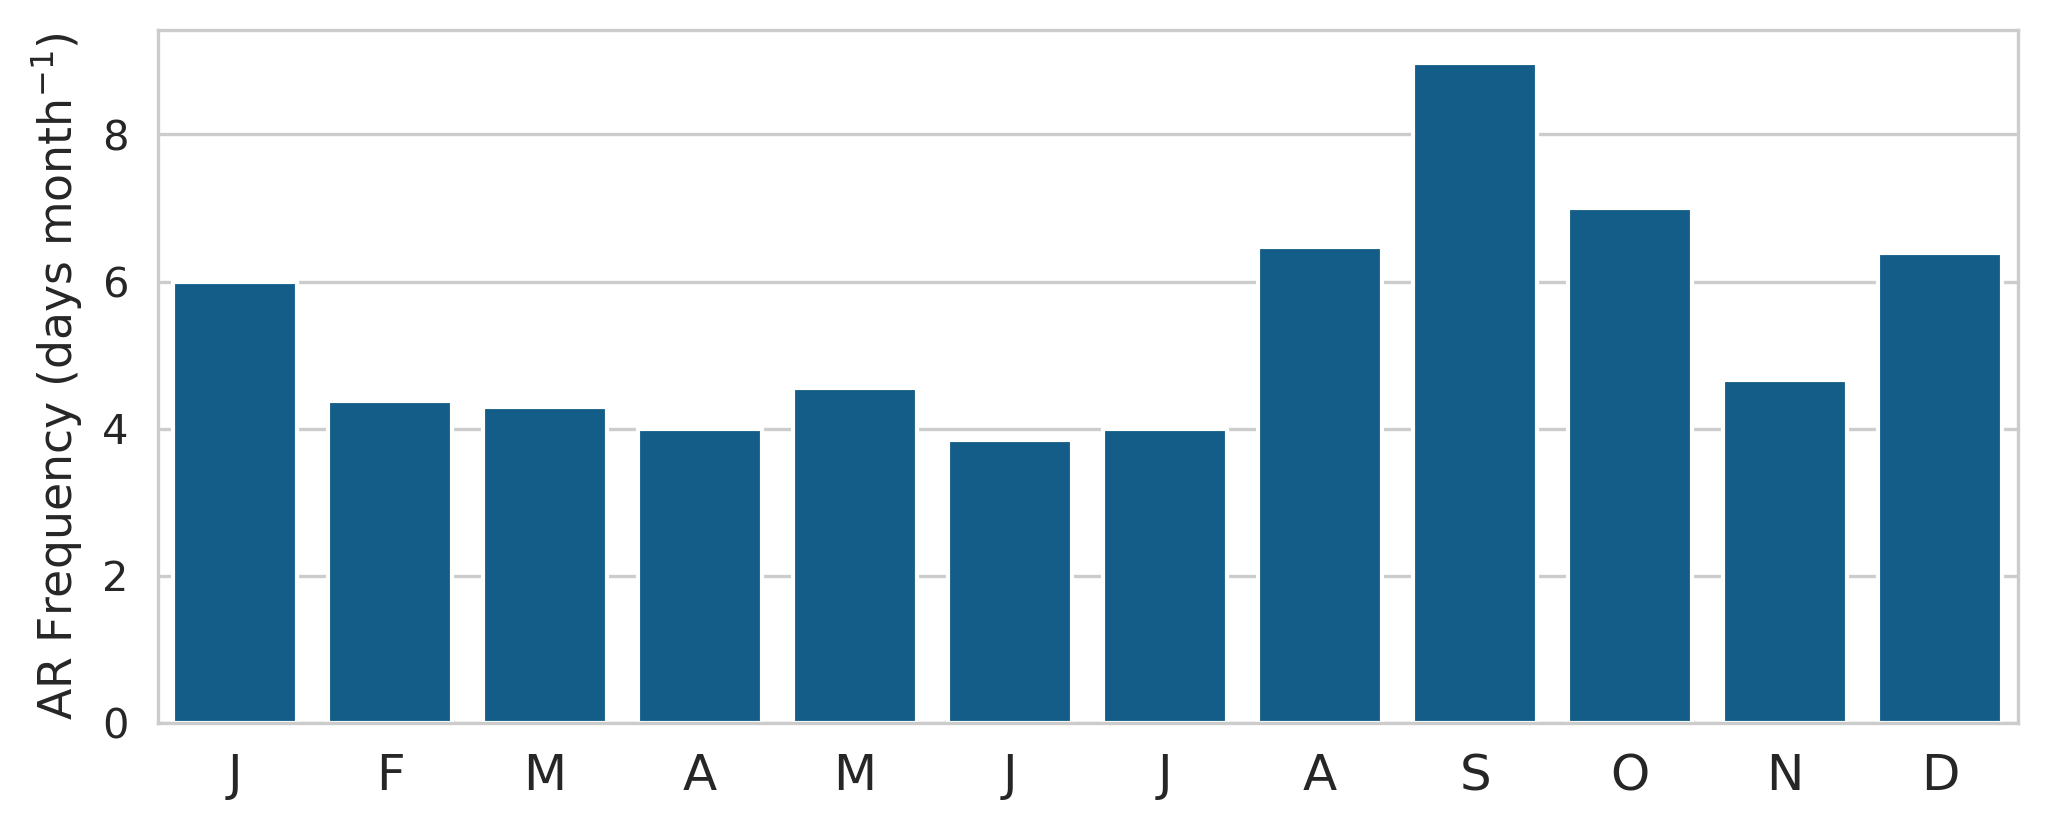

In [22]:
fname = path_to_figs + 'ar_barplot'
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((8.0,3.0))
fig.dpi = 300
nplots=1

# Set custom color palette
colors = ["#00629B"]
sns.set_palette(sns.color_palette(colors))
columns=['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
          
sns.set_style("whitegrid")
# sns.set_context("paper")
sns.despine()

for i in np.arange(nplots):
    ax = fig.add_subplot(1, 1, i+1)
    sns.barplot(x=np.arange(1, 13, 1), y=clim_ct, color=ucsd_colors['navy'])
#     ax.set_title('AR Frequency (1980-2015)', fontsize=12)
    ax.set_ylabel('AR Frequency (days month$^{-1}$)', fontsize=11)
    ax.set_xticklabels(columns, fontsize=12)
#     ax.legend(loc='upper left')
    
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
plt.show()



In [23]:
# how many hours per AR - check potential categories
pd.unique(duration_df.duration)

array([ 12.,  18.,   6.,  24.,  36.,  30.,  84.,  42.,  90.,  48., 108.,
        60.,  96.,  72., 288., 150.,  54., 120., 138.,  78.,  66., 156.,
       168., 102., 174., 126., 264., 114.])

In [24]:
bins = np.array([[0, 24], [24, 72], [72, 4*24], [4*24, 100*24]]) # <1 days, 1-5 days, >5 days
size, freq = duration_stats(duration_df.duration, bins)
print(sum(freq))
print(freq)
freqs= [freq]

100.0
[68.58757062146893, 26.949152542372882, 2.3163841807909606, 2.1468926553672314]


../figs/donut_plot_duration_freq.png


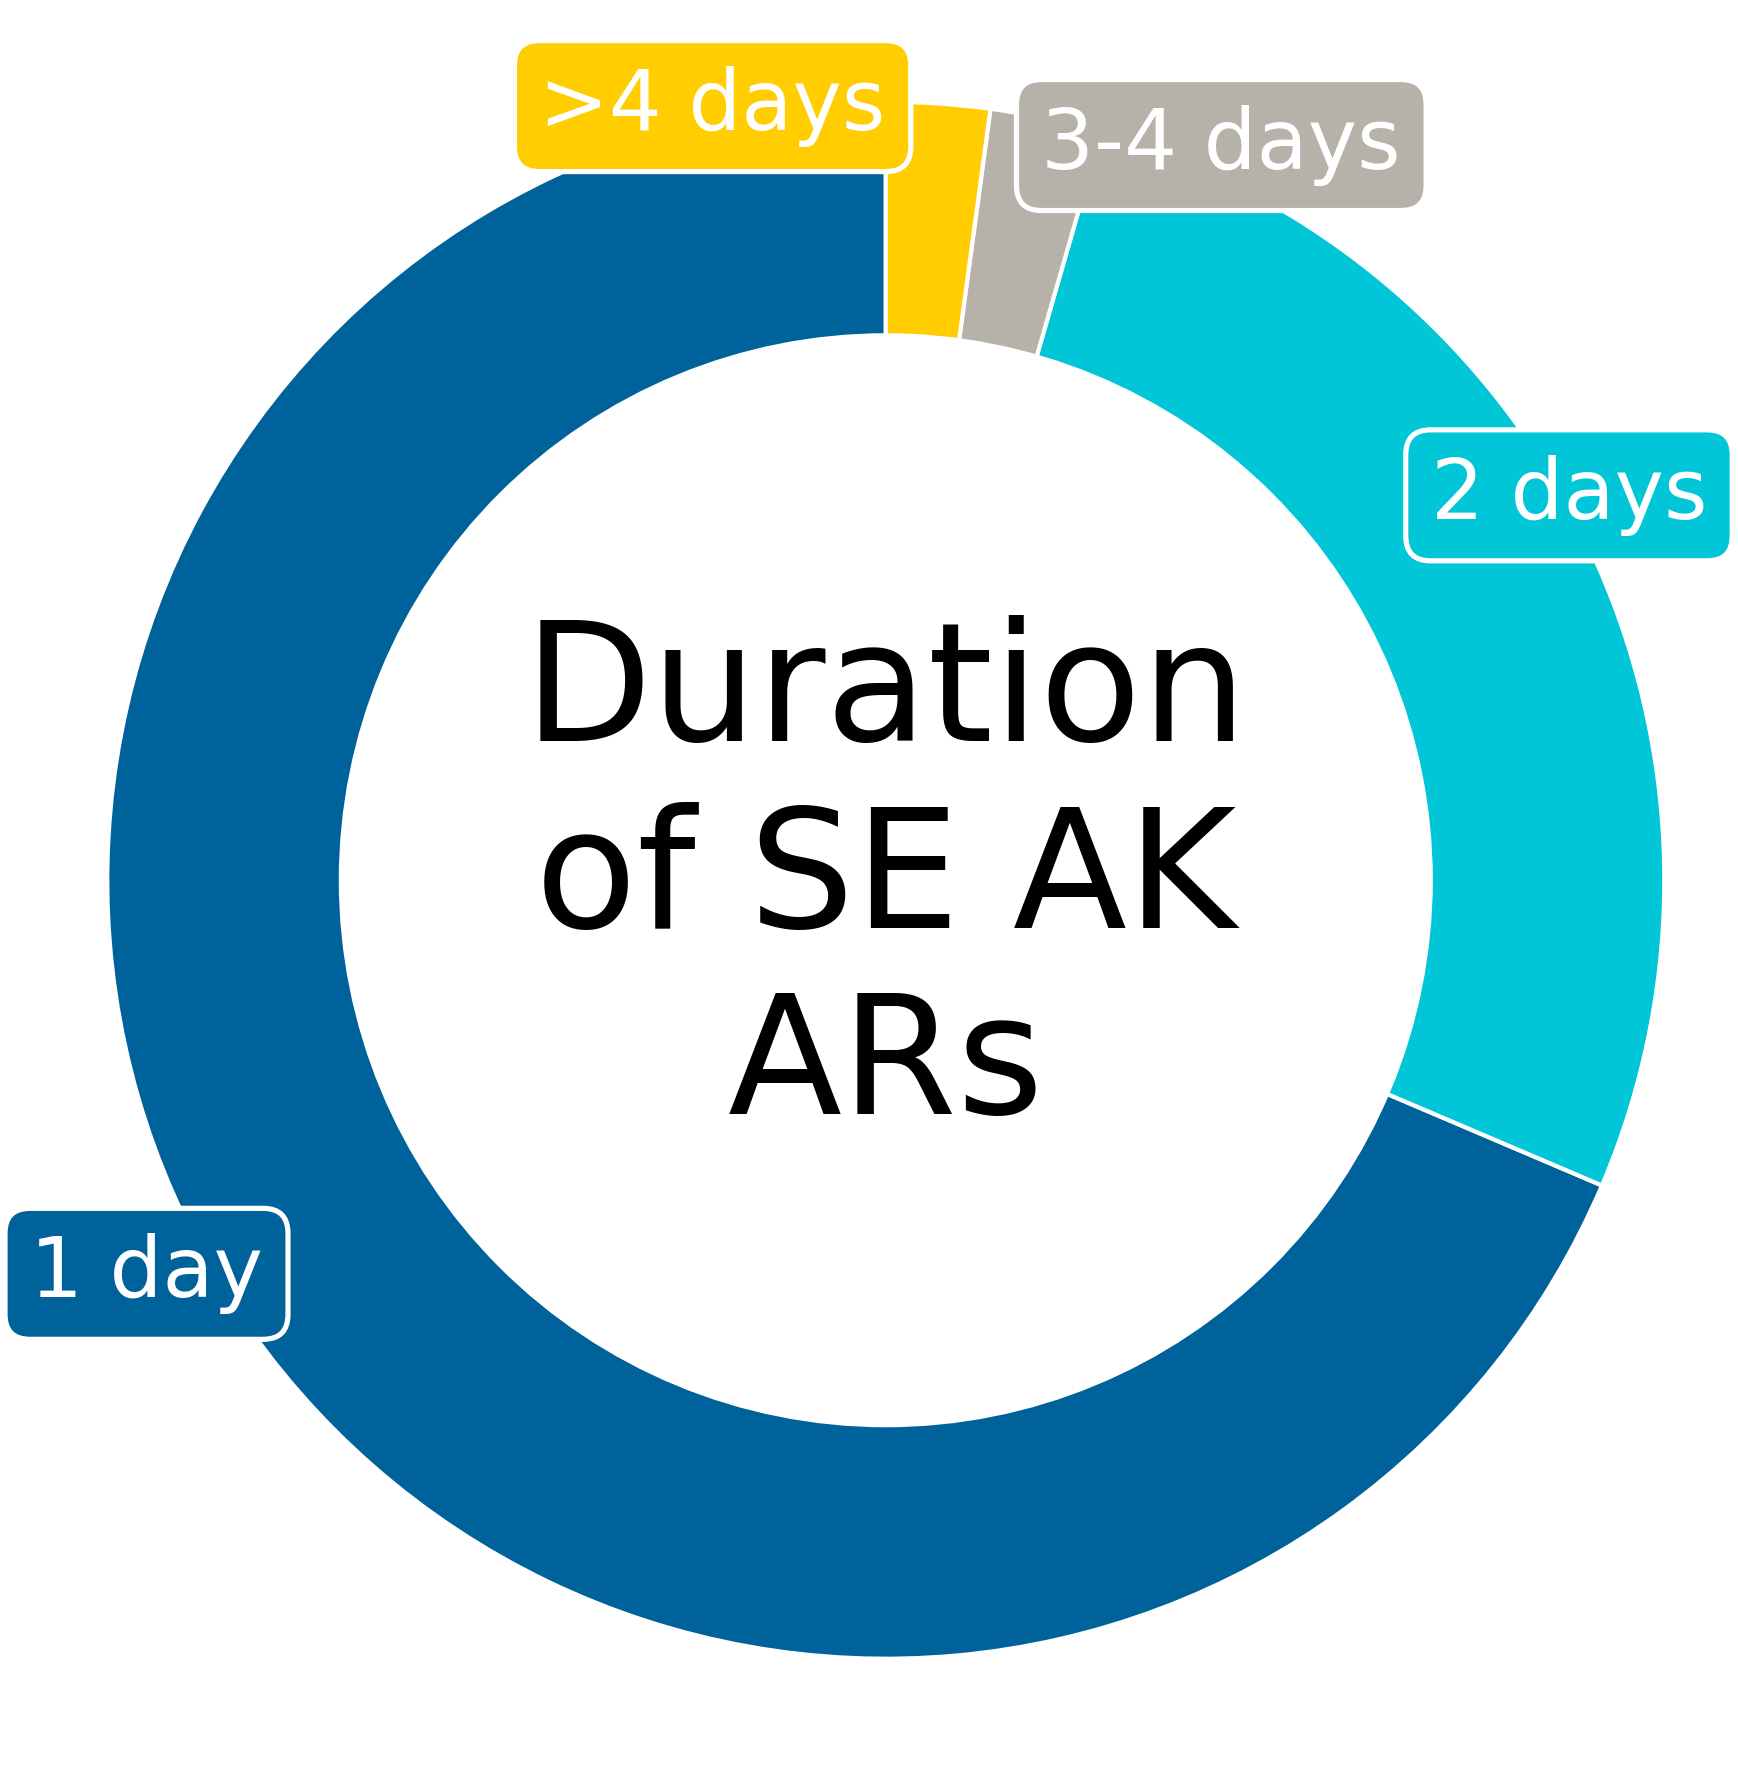

In [25]:
fname = path_to_figs + 'donut_plot_duration_freq'
fmt = 'png'

xs = [-0.8, 0.7, 0.2, 0.] # x points of the label
ys = [-0.6, 0.4, 0.85, 0.9] # y points of the label
lbl_align = ['right', 'left', 'left', 'right'] # where the labels go

# Pie chart
plt_title = 'Duration of SE AK ARs'
labels = ['1 day', '2 days', '3-4 days', '>4 days']
colors = [ucsd_colors['navy'], ucsd_colors['aqua'], ucsd_colors['grey'], ucsd_colors['yellow']]
 
fig = plt.figure()
fig.set_size_inches((6.,6.))
fig.dpi = 300
nrows = 1
ncols = 1
nplots = nrows*ncols
for i in np.arange(nplots):
    ax = plt.subplot(nrows, ncols, i+1)
    ax.pie(freqs[i], colors = colors, autopct=None, startangle=90)

    #draw circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    ax.add_artist(centre_circle)
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax.axis('equal')  
    ax.annotate(textwrap.fill(plt_title, 8), # this is the text
                   (0,-0.3), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,0), # distance from text to points (x,y)
                    ha='center', # horizontal alignment can be left, right or center
                    xycoords='data',
                    zorder=102,
                    fontsize=40,
                    color='k')
    
    ## Plot the labels
    # zip joins x and y coordinates in pairs
    for x,y,z,ha,face in zip(xs,ys, labels, lbl_align,colors):

        ax.annotate(z, # this is the text
                   (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,12), # distance from text to points (x,y)
                    ha=ha, # horizontal alignment can be left, right or center
                    bbox=dict(boxstyle="round,pad=0.3", fc=face, ec="white", lw=1.25, alpha=1.),
                    xycoords='data',
                    zorder=102,
                    fontsize=20,
                    color="white")

plt.tight_layout()
# plt.show()

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=300)

plotFile = fname + '.png'
print(plotFile)